# QML-HEP GSoC 2024 Tasks

### Task II: Classical Graph Neural Network (GNN

● Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.

● Discuss the resulting performance of the 2 chosen architectures.

## Importing Required Libraries

In [1]:
!pip install energyflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.5/700.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.2/502.2 kB 11.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tf_keras_model_v2 import get_particle_net_lite_v2
import energyflow
from tensorflow import keras

## Dataset

#### X: (100000,M,4)
* 50k quark and 50k gluon jets
* where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles)
* features of each particle are its **pt, rapidity, azimuthal angle, and pdgid**


#### y: (100000,)

an array of labels for the jets where **gluon is 0** and **quark is 1**

In [3]:
qg_dataset = energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia',with_bc=False, cache_dir='~/.energyflow')

URL fetch failure on https://www.dropbox.com/s/fclsl7pukcpobsb/QG_jets.npz?dl=1: None -- Not Found
Failed to download QG_jets.npz from source 'dropbox', trying next source...


In [4]:
x = qg_dataset[0]

print("Shape of X: ", x.shape)
print("X: pt, rapidity, azimuthal angle, and pdgid ",x[0][0])

Shape of X:  (100000, 139, 4)
X: pt, rapidity, azimuthal angle, and pdgid  [ 0.26876914  0.35690317  4.74138734 22.        ]


In [5]:
y = qg_dataset[1]
print("y: 0 or 1 (gluon or quark): ",y[0])
print("Shape of y:", y.shape)
y = keras.utils.to_categorical(y)
print("y after one-Hot Encoding: [quark, gluon]  ", y[0])
print("Shape of y:", y.shape)

y: 0 or 1 (gluon or quark):  1.0
Shape of y: (100000,)
y after one-Hot Encoding: [quark, gluon]   [0. 1.]
Shape of y: (100000, 2)


In [6]:
# Shuffling the dataset to avoiad any unpecedented bias
x, y = shuffle(x, y, random_state=0)

# Splitting the dataset into train (70% of the datapoints) and test (30% of the datapoints)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

# Further, splitting the test into 50% test and 50% validation dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print("Shape of training dataset :", x_train.shape, y_train.shape)
print("Shape of testing dataset :", (x_test.shape, y_test.shape))
print("Shape of validation dataset :", (x_val.shape, y_val.shape))

Shape of training dataset : (70000, 139, 4) (70000, 2)
Shape of testing dataset : ((15000, 139, 4), (15000, 2))
Shape of validation dataset : ((15000, 139, 4), (15000, 2))


In [7]:
# Masking

# This function call computes the sum of x_train along its third axis (axis=2).
# For a 3D array, this means it's adding up the values across the vector components of each feature,
# effectively reducing the 3D array to a 2D array.

mask_train = np.sum(x_train, axis=2)
print(f"Before: The shape of x_train is {x_train.shape} where {x_train.shape[0]} is the number of samples, {x_train.shape[1]} is the number of features, and {x_train.shape[2]} is the number of components in each feature vector")
print(f"After: The result will have a shape of {mask_train.shape}, where each element now represents the sum of the components for a given feature in the sample.\n")

print(f"Instance of Masked X:\n {mask_train[0]}")

# Binary Mask

# Identifying Non-Zero Features:
# By summing across the components, we effectively measure the "activity" or "presence" of each feature in each sample.
# If a feature vector is entirely zeros, its sum will be zero, indicating no activity or presence.

mask_train = np.array(mask_train != 0, np.float32)

# Reshaping mask for a third axis
mask_train = mask_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(f"Binary Mask:\n {mask_train[0]}")

Before: The shape of x_train is (70000, 139, 4) where 70000 is the number of samples, 139 is the number of features, and 4 is the number of components in each feature vector
After: The result will have a shape of (70000, 139), where each element now represents the sum of the components for a given feature in the sample.

Instance of Masked X:
 [   29.20243269    27.50561143    30.26089051   220.41819997
    27.95042087    28.15969933   329.0687446     27.57628735
  -206.06003465   218.08468374    26.41602355    27.02195013
    31.79622486    26.59246689    26.88924931  -202.09822736
    26.71899363    31.23462352  -310.42681747    27.70451205
    30.7169403   -198.56554041  2233.77838649    36.42720615
    29.23621805  -187.38676832    33.46071738   268.17256202
    32.3521241  -2054.01856237   118.7019814     56.63953271
   151.53934524    57.07618763     0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.

In [8]:
# Similarly for Test and Validation dataset
mask_val = np.sum(x_val, axis=2)
mask_val = np.array(mask_val != 0, np.float32)
mask_val = mask_val.reshape(x_val.shape[0], x_val.shape[1], 1)

mask_test = np.sum(x_test, axis=2)
mask_test = np.array(mask_test != 0, np.float32)
mask_test = mask_val.reshape(x_test.shape[0], x_test.shape[1], 1)


ParticleNet model requires a 3-dim dataset with the following 3 features:

1. **points**: contain rapidity, azimuthal angle used for computing the distance of KNN
2. **features**: the 4 features of the particles
3. **mask**: mask array taking a value of 0 for padded positions





In [9]:
train_dataset = {
    'points': x_train[:, :, 1:3],
    'features': x_train,
    'mask': mask_train
}

test_dataset = {
    'points': x_test[:, :, 1:3],
    'features': x_test,
    'mask': mask_test
}

val_dataset = {
    'points': x_val[:, :, 1:3],
    'features': x_val,
    'mask': mask_val
}

### ParticleNet Model

In [10]:
num_classes = 2
shapes = {k:train_dataset[k].shape[1:] for k in train_dataset}
# shapes: {'points': (139, 2), 'features': (139, 4), 'mask': (139, 1)}

model = get_particle_net_lite_v2(num_classes, shapes)

# Training parameters
batch_size = 1024
epochs = 100

# Learning Rate
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    print('Learning rate: %f' % lr)
    return lr

# Compiling Model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.legacy.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy',keras.metrics.AUC()])

# Model Summary
model.summary()

Learning rate: 0.001000
Model: "ParticleNetLiteV2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 points (InputLayer)         [(None, 139, 2)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 139, 64)              192       ['points[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 139, 64)              256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 features (InputLayer)       [(None, 139, 4)]             

In [11]:
# Setting the callbacks
checkpoint_path_1 = "GNN_checkpoints/cp.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)

cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_1, verbose=0, save_weights_only=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [lr_scheduler, progress_bar, cp_callback]

# Fitting the model on training dataset
history = model.fit(train_dataset, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(val_dataset, y_val),
                          shuffle=True,
                          callbacks=callbacks)

Learning rate: 0.001000
Epoch 1/100
69/69 [==============================] - 277s 4s/sample - loss: 0.8111 - accuracy: 0.7113 - auc: 0.7557 - val_loss: 0.9115 - val_accuracy: 0.5273 - val_auc: 0.6334 - lr: 0.0010
Learning rate: 0.001000
Epoch 2/100
69/69 [==============================] - 278s 4s/sample - loss: 0.5106 - accuracy: 0.7643 - auc: 0.8346 - val_loss: 0.8152 - val_accuracy: 0.5039 - val_auc: 0.6340 - lr: 0.0010
Learning rate: 0.001000
Epoch 3/100
69/69 [==============================] - 265s 4s/sample - loss: 0.5013 - accuracy: 0.7701 - auc: 0.8399 - val_loss: 0.8778 - val_accuracy: 0.5016 - val_auc: 0.6380 - lr: 0.0010
Learning rate: 0.001000
Epoch 4/100
69/69 [==============================] - 286s 4s/sample - loss: 0.5034 - accuracy: 0.7703 - auc: 0.8390 - val_loss: 0.9199 - val_accuracy: 0.5002 - val_auc: 0.6434 - lr: 0.0010
Learning rate: 0.001000
Epoch 5/100
69/69 [==============================] - 272s 4s/sample - loss: 0.4973 - accuracy: 0.7727 - auc: 0.8422 - val_lo

KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history, epochs):
    # Set up the plotting parameters
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    titles = ['Loss of ParticleNet Lite Model', 'Accuracy of ParticleNet Lite Model', 'AUC of ParticleNet Lite Model']
    metrics = [('loss', 'val_loss'), ('accuracy', 'val_accuracy'), ('auc', 'val_auc')]
    y_labels = ['Loss', 'Accuracy', 'AUC']
    colors = [('blue', 'green'), ('blue', 'green'), ('blue', 'green')]

    # Generate each subplot
    for ax, metric, title, y_label, color in zip(axes, metrics, titles, y_labels, colors):
        epochs_range = np.linspace(1, epochs, epochs, dtype=int)
        ax.plot(epochs_range, history.history[metric[0]], label='Training', color=color[0])
        ax.plot(epochs_range, history.history[metric[1]], label='Validation', color=color[1])
        ax.set_xlabel('Epochs')
        ax.set_ylabel(y_label)
        ax.set_title(title)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


In [14]:
loss, acc, auc = model.evaluate(test_dataset, y_test)
print("Evaluation Metric of model on test data")
print("Loss:", loss)
print("Accuracy:", acc)
print("AUC:", auc)

469/469 [==============================] - 8s 17ms/step - loss: 0.5077 - accuracy: 0.7819 - auc: 0.8568
Evaluation Metric of model on test data
Loss: 0.5076521635055542
Accuracy: 0.7818666696548462
AUC: 0.8568345308303833


469/469 [==============================] - 14s 30ms/step


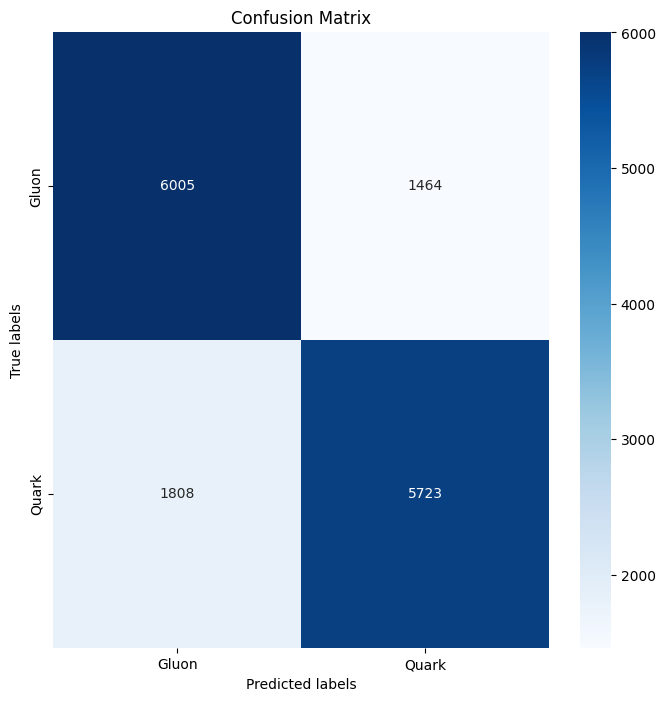

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_dataset)

def plot_conf_matrix(y_test, predictions, class_names):
    # Adjust based on y_test and predictions are one-hot encoded
    if y_test.ndim > 1:
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(predictions, axis=1)
    else:
        y_true = y_test
        y_pred = np.round(predictions).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


class_names = ['Gluon', 'Quark']
plot_conf_matrix(y_test, y_pred, class_names)